In [2]:
'''This code is meant to be a helpful introduction to processing flow cytometry data from the SONY FACS SH800'''
#press the shift and enter/return buttons simultaneously to run each block of code

'This code is meant to be a helpful introduction to processing flow cytometry data from the SONY FACS SH800'

In [3]:
from openpyxl import load_workbook
import pandas as pd
import platform
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.colors import LogNorm
from scipy import stats
from IPython.display import Image, display
import fractions
import FlowCal as FC
%matplotlib inline
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 0.75
mpl.rcParams['mathtext.default'] = 'regular'

#if any errors occur after running this code, make sure that all of the packages imported above have been 
#added and updated to the latest versions in your terminal or through 
#Anaconda Navigator -> Environments -> Base (Root) triangle -> Open Terminal
#then write, "pip install" and the name of the package you may need 

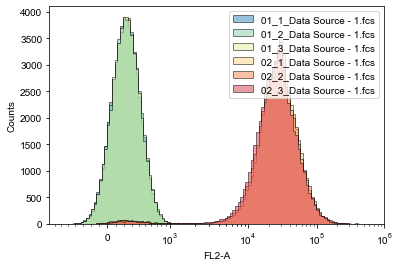

In [6]:
## IMPORT DATA ##

#input the date the data was collected on. This will automatically date your output png/svg plots as 
#well as excel spreadsheets later on in the code
date = '20201201'

#add the names of the fcs files that are going to be analyzed and processed
#note that in order for this to work, your fcs files need to be located in the same folder as the location of this 
#python jupyter notebook. 
#In addition, please follow the naming scheme of strain number (i.e. 01,10,15,etc) followed by an _ and the replicate number (i.e. 1,2,3,etc)
filenames = ['01_1_Data Source - 1.fcs','01_2_Data Source - 1.fcs','01_3_Data Source - 1.fcs',
             '02_1_Data Source - 1.fcs','02_2_Data Source - 1.fcs','02_3_Data Source - 1.fcs']

#this function will open and read the data files indicated in "filenames" above
data = [FC.io.FCSData(filename) for filename in filenames]

#plot your raw data all on one graph
FC.plot.hist1d(data, channel='FL2-A', alpha=0.5, bins=128)
#change location of legend by changing 'loc=' parameter to upper/lower left/right/center
#add a # to the line below to remove the legend
plt.legend(filenames, loc='best')

## uncomment either or both of the lines below to save a copy of your plot as a picture in your folder
# plt.savefig(date+'_raw_FL_all.png', bbox_inches='tight', dpi=300)
# plt.savefig(date+'_raw_FL_all.svg', bbox_inches='tight', dpi=300)

plt.show()

In [15]:
## TEST BLOCK ##
#add the code you want to test below, then press SHIFT ENTER:


In [16]:
## MAKE TABLE FOR PROCESSED DATA ##
#this block will be used to create your table (referred to as dataframe) of information for processing your data
#first, we need to create lists of information corresponding to the files described in "filenames"

#the three lists in the three lines below are automatically determined from your "filenames" list in the IMPORT DATA block
name = [filenames[i] for i in range(len(filenames))]
strainnum = [filenames[i][0:2] for i in range(len(filenames))]
rep = [filenames[i][3:4] for i in range(len(filenames))]

#define the strain for each sample by altering the string ('TG1' in this case) and changing the number to the 
#number of times that strain is present in your dataset. 
#the output of this function creates a list of the strain names for each sample
strain = ['TG1']*6

#define the plasmid names for each sample. Here, you see how the plus sign adds the second set of strings 
#to the same list called plasmid. To see how this works, take the code on the next line and add to the TEST BLOCK 
plasmid = ['pJEC103']*3 + ['pLCG067']*3

#define the target length of each sample. If this parameter doesn't apply to your experiment, you are welcome to 
#skip it or alter it to fit your parameter of interest
targetlength = [None]+[0]*2+[164]*3

#this line will ensure that you have the right number of each component for the table
#you must have the same number of each list in order to proceed, otherwise, you will get an assertion error and 
#need to go back and check your code
assert len(filenames) == len(name) == len(strainnum) == len(strain) == len(plasmid) == len(rep)


#build your table (dataframe)
df = pd.DataFrame(columns = ['Filename','Strain_#','Strain','Plasmid','Replicate','Target_length','Mean_FL_ungated','Mean_FL_gated','Mean_FL_gated_autosub'])
df['Filename'] = name
df['Strain_#'] = strainnum
df['Strain_#'] = df['Strain_#'].astype(float)
df['Strain'] = strain
df['Plasmid'] = plasmid
df['Replicate'] = rep
df['Target_length'] = targetlength
df

,Filename,Strain_#,Strain,Plasmid,Replicate,Target_length,Mean_FL_ungated,Mean_FL_gated,Mean_FL_gated_autosub
0,01_1_Data Source - 1.fcs,1.0,TG1,pJEC103,1,NaN,NaN,NaN,NaN
1,01_2_Data Source - 1.fcs,1.0,TG1,pJEC103,2,0.0,NaN,NaN,NaN
2,01_3_Data Source - 1.fcs,1.0,TG1,pJEC103,3,0.0,NaN,NaN,NaN
3,02_1_Data Source - 1.fcs,2.0,TG1,pLCG067,1,164.0,NaN,NaN,NaN
4,02_2_Data Source - 1.fcs,2.0,TG1,pLCG067,2,164.0,NaN,NaN,NaN
5,02_3_Data Source - 1.fcs,2.0,TG1,pLCG067,3,164.0,NaN,NaN,NaN


In [18]:
##  CONDENSE DATA ##
#this code block combines all fcs data into a list of arrays
transformed_au = []
for file in range(len(filenames)):
    load = FC.io.FCSData(filenames[file])
    transformed_au.append(load)
transformed_au

[FCSData([[ 2.9436570e-01,  2.1049312e+03,  2.2456001e+03, ...,
            2.2104395e+01, -2.8002832e+01,  0.0000000e+00],
          [ 2.9477715e-01,  8.6158478e+02,  1.0707200e+03, ...,
            7.9628906e+00, -1.7090723e+01,  7.4320316e+00],
          [ 2.9500571e-01,  8.1180200e+02,  1.0897600e+03, ...,
           -3.8546291e+01,  2.6528223e+01,  6.8716798e+00],
          ...,
          [ 1.1003772e+01,  6.7992767e+02,  8.8816003e+02, ...,
            1.0617188e+00,  2.5997364e+01, -1.7842774e+00],
          [ 1.1003840e+01,  8.3339026e+02,  1.0953600e+03, ...,
           -2.9374220e+01, -1.6958008e+00, -1.3905567e+01],
          [ 1.1003874e+01,  9.9643781e+02,  1.2398400e+03, ...,
           -3.6703030e+01,  1.8388380e+01,  2.2826954e+01]], dtype=float32),
 FCSData([[ 3.5646856e-01,  9.5994122e+02,  1.0908800e+03, ...,
            5.0033497e+01,  4.3132324e+01, -4.3943362e+00],
          [ 3.5683429e-01,  3.5272805e+03,  4.0868801e+03, ...,
            1.5409668e+01, -6.166816

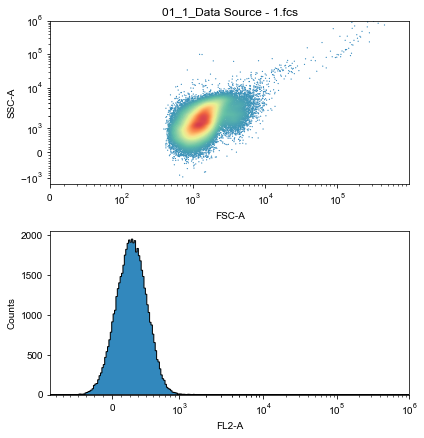

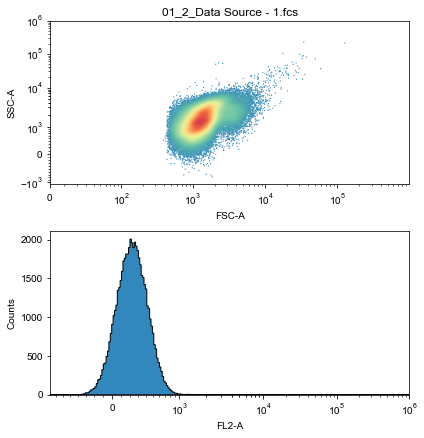

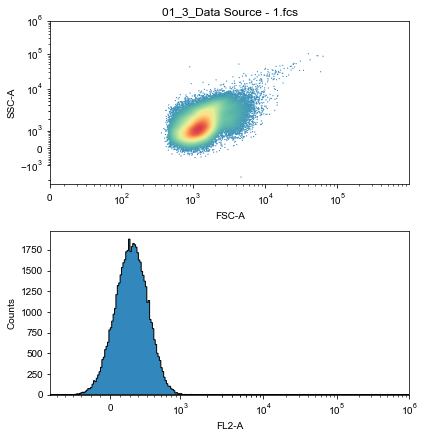

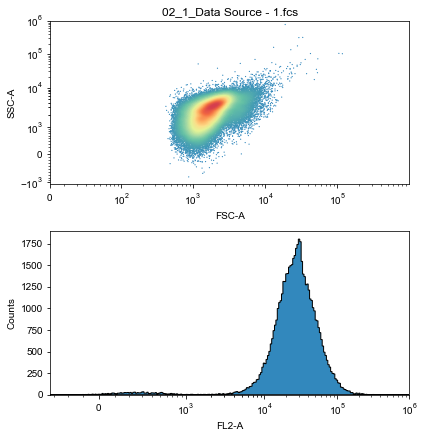

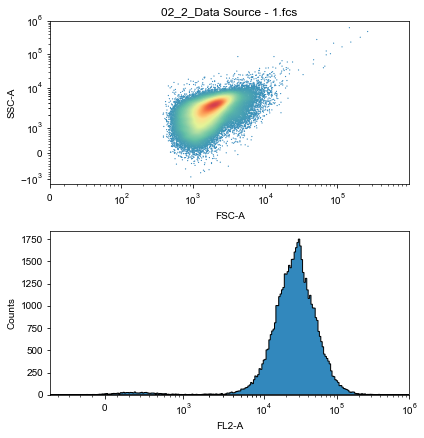

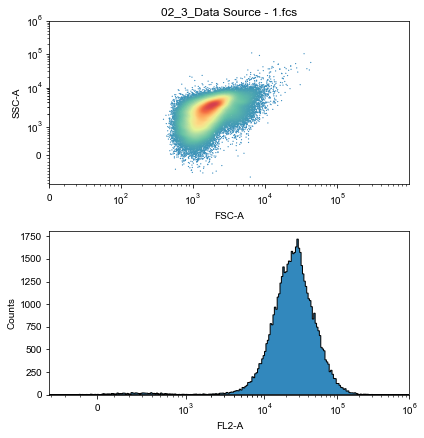

In [19]:
## LOOK AT RAW PLOTS INDIVIDUALLY ##
#comment out the plt.savefig line if you don't want to save these individual figures
for i in range(len(filenames)):
    ind = filenames[i][0:4]
    FC.plot.density_and_hist(transformed_au[i],density_channels=['FSC-A', 'SSC-A'],density_params={'mode':'scatter'},hist_channels=['FL2-A'])
    plt.tight_layout()
    plt.savefig(date+'_density_histogram_'+ind+'.png', bbox_inches='tight', dpi=150)
    plt.show()

In [22]:
# ## DETERMINE DENSITY GATING BY LOOKING AT INDIVIDUAL PLOTS ##
# #change the sample you are looking at by altering the 0 in 'transformed_au[]'
# #change the gating in this density gate by changing the 'gate_fraction=' value (0.99 gates few cells, 0.1 gates many)

# gate_1 = FC.gate.density2d(transformed_au[0],channels=['FSC-A', 'SSC-A'], gate_fraction=0.99)
# FC.plot.density_and_hist(gate_1,density_channels=['FSC-A', 'SSC-A'],density_params={'mode':'scatter'},hist_channels=['FL2-A'])
# plt.tight_layout()
# plt.show()

In [23]:
## GATE THE ENTIRE DATASET USING THE GATE SET IN THE ABOVE CODE BLOCK ##
scatter = []
for i in range(len(transformed_au)):
#gate density chosen based on transformed_au to get one population. Change 'gate_fraction' value to reflect desired gate
    gate = FC.gate.density2d(transformed_au[i], channels=['FSC-A', 'SSC-A'], gate_fraction=0.8)
    scatter.append(gate)
scatter 

[FCSData([[ 2.9436570e-01,  2.1049312e+03,  2.2456001e+03, ...,
            2.2104395e+01, -2.8002832e+01,  0.0000000e+00],
          [ 2.9477715e-01,  8.6158478e+02,  1.0707200e+03, ...,
            7.9628906e+00, -1.7090723e+01,  7.4320316e+00],
          [ 2.9500571e-01,  8.1180200e+02,  1.0897600e+03, ...,
           -3.8546291e+01,  2.6528223e+01,  6.8716798e+00],
          ...,
          [ 1.1003612e+01,  7.7200226e+02,  8.4000000e+02, ...,
            1.8329395e+01,  1.0941602e+01,  2.4861916e+01],
          [ 1.1003840e+01,  8.3339026e+02,  1.0953600e+03, ...,
           -2.9374220e+01, -1.6958008e+00, -1.3905567e+01],
          [ 1.1003874e+01,  9.9643781e+02,  1.2398400e+03, ...,
           -3.6703030e+01,  1.8388380e+01,  2.2826954e+01]], dtype=float32),
 FCSData([[ 3.5646856e-01,  9.5994122e+02,  1.0908800e+03, ...,
            5.0033497e+01,  4.3132324e+01, -4.3943362e+00],
          [ 3.5705143e-01,  1.7059166e+03,  1.9219200e+03, ...,
            2.6660938e+01,  1.420048

In [24]:
## CREATE LISTS OF MEAN VALUES FOR EACH SAMPLE (GATED AND UNGATED) ##

mean_ungated = []
mean_gated = []
for j in range(len(scatter)):
    ungated = FC.stats.mean(transformed_au[j], channels='FL2-A')
    gated = FC.stats.mean(scatter[j], channels='FL2-A')
    mean_ungated.append(ungated)
    mean_gated.append(gated)
print(mean_ungated)
print(mean_gated)

[263.11697, 232.74167, 231.5501, 32454.35, 32088.848, 30535.588]
[225.19136, 221.41467, 218.2762, 30078.525, 29843.102, 28064.375]


In [25]:
## ADD PROCESSED MEAN FL VALUES TO THE TABLE (DATAFRAME) MADE EARLIER ##
df.Mean_FL_ungated = mean_ungated
df.Mean_FL_gated = mean_gated
df

,Filename,Strain_#,Strain,Plasmid,Replicate,Target_length,Mean_FL_ungated,Mean_FL_gated,Mean_FL_gated_autosub
0,01_1_Data Source - 1.fcs,1.0,TG1,pJEC103,1,NaN,263.116974,225.191360,NaN
1,01_2_Data Source - 1.fcs,1.0,TG1,pJEC103,2,0.0,232.741669,221.414673,NaN
2,01_3_Data Source - 1.fcs,1.0,TG1,pJEC103,3,0.0,231.550095,218.276199,NaN
3,02_1_Data Source - 1.fcs,2.0,TG1,pLCG067,1,164.0,32454.349609,30078.525391,NaN
4,02_2_Data Source - 1.fcs,2.0,TG1,pLCG067,2,164.0,32088.847656,29843.101562,NaN
5,02_3_Data Source - 1.fcs,2.0,TG1,pLCG067,3,164.0,30535.587891,28064.375000,NaN


In [26]:
## CREATE A CONDENSED TABLE OF STRAINS, REPLICATES, MEAN FL, AND STD FL VALUES ##
df_plot = df.copy()
df_plot = df_plot.pivot_table(index=['Strain_#'],columns='Replicate',values='Mean_FL_gated',aggfunc='first')

avgbar = df_plot.mean(axis=1)
stdbar = df_plot.std(axis=1)
df_plot['AvgRep'] = avgbar
df_plot['StdRep'] = stdbar
df_plot = df_plot.reset_index()
## uncomment the line below to make an excel file of this table that can be found in your folder
# df_plot.to_excel(date+'_avgstd.xlsx')
df_plot

Replicate,Strain_#,1,2,3,AvgRep,StdRep
0,1.0,225.191360,221.414673,218.276199,221.627411,3.462486
1,2.0,30078.525391,29843.101562,28064.375000,29328.667318,1101.218595


In [27]:
## CREATE A TABLE OF MEAN AND STD FL VALUES FROM REPLICATES ##
#average the FL from replicate values
df_2 = df.copy()
df_2 = df_2.groupby(['Strain_#'], sort=False)['Mean_FL_gated'].mean()

df_2 = df_2.to_frame()
df_2 = df_2.reset_index()
df_2.rename(columns={'Mean_FL_gated':'Mean_FL'}, inplace=True)
df_2.columns.values

#find the standard deviation of FL replicates
df_3 = df.copy()
df_3 = df_3.groupby(['Strain_#'], sort=False)['Mean_FL_gated'].std()

df_3 = df_3.to_frame()
df_3 = df_3.reset_index()
df_3.rename(columns={'Mean_FL_gated':'Std_FL'}, inplace=True)
df_3.columns.values

#merge the two dfs into a single df
df_4 = df_2.merge(df_3, how='left', on=['Strain_#'])
df_4

,Strain_#,Mean_FL,Std_FL
0,1.0,221.627411,3.462486
1,2.0,29328.667318,1101.218595


In [28]:
## SUBTRACT AUTOFLUORESCENCE ##
autosub = []
for i in range(len(df)):
    #change the 0 in 'df_4['Mean_FL'][0]' to the indexed number that corresponds to your autofluorescent cell control
    x = list(df['Mean_FL_gated'])[i]-df_4['Mean_FL'][0]
    autosub.append(x)
df['Mean_FL_gated_autosub'] = autosub
#in the line below, remove your autofluorescent cell control strain by indicating the plasmid name of it
df = df[~(df['Plasmid']=='pJEC103')]
df

,Filename,Strain_#,Strain,Plasmid,Replicate,Target_length,Mean_FL_ungated,Mean_FL_gated,Mean_FL_gated_autosub
3,02_1_Data Source - 1.fcs,2.0,TG1,pLCG067,1,164.0,32454.349609,30078.525391,29856.897980
4,02_2_Data Source - 1.fcs,2.0,TG1,pLCG067,2,164.0,32088.847656,29843.101562,29621.474152
5,02_3_Data Source - 1.fcs,2.0,TG1,pLCG067,3,164.0,30535.587891,28064.375000,27842.747589


In [29]:
## CREATE A TABLE OF *AUTOSUBTRACTED* MEAN AND STD FL VALUES FROM REPLICATES ##
#average the autosubtracted mean FL from replicate values
df_5 = df.copy()
df_5 = df_5.groupby(['Strain_#'], sort=False)['Mean_FL_gated_autosub'].mean()

df_5 = df_5.to_frame()
df_5 = df_5.reset_index()
df_5.rename(columns={'Mean_FL_gated_autosub':'Mean_FL'}, inplace=True)
df_5.columns.values

#find the standard deviation of autosubtracted mean FL from replicates
df_6 = df.copy()
df_6 = df_6.groupby(['Strain_#'], sort=False)['Mean_FL_gated_autosub'].std()

df_6 = df_6.to_frame()
df_6 = df_6.reset_index()
df_6.rename(columns={'Mean_FL_gated_autosub':'Std_FL'}, inplace=True)
df_6.columns.values

#merge the two dfs into a single df
df_7 = df_5.merge(df_6, how='left', on=['Strain_#'])
df_7

,Strain_#,Mean_FL,Std_FL
0,2.0,29107.039907,1101.218595


In [30]:
import seaborn as sns
import matplotlib.patches as mpatches

[Text(0, 0, '0')]

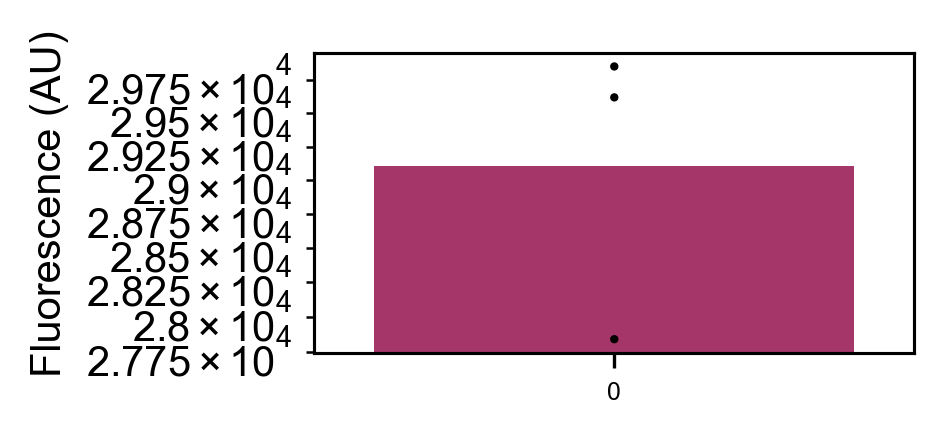

In [32]:
## PLOT YOUR MEAN FL DATA IN A BAR PLOT WITH STRIP PLOT TO VISUALIZE DATA POINTS ##
fig = plt.figure(figsize=(2,1),dpi=300)
ax = fig.add_axes([0,0,1,1])

## set the order that you want the data to be shown in bar plot from left to right using the strain number 
## example order = [1,2,3,4,5,6,7]
order = [2]

palette = {'#B62467'}
palette2 = {'k'}

ax = sns.barplot(x='Strain_#', y='Mean_FL', data=df_7, order=order, palette=palette, ci=None, alpha=1)
ax = sns.stripplot(x='Strain_#', y='Mean_FL_gated_autosub', data=df, order=order, palette=palette2, 
                   dodge=True, size=2, jitter=False)

## uncomment this code to remove upper and right lines boxing in data
# sns.despine()
# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(1.25)
# ax.xaxis.set_tick_params(width=1.25)
# ax.yaxis.set_tick_params(width=1.25)

## uncomment this code to add custom legend labels
# grey_patch = mpatches.Patch(color='#B62467', label='1% Arabinose')
# blue_patch = mpatches.Patch(color='silver', label='None')
## fontsize can also be an integer (like 6) and location can be 'best', upper/lower right/center/left
# ax.legend(handles=[grey_patch,blue_patch],frameon=False, fontsize='x-small', loc='upper right')

## uncomment this code to set the y-axis limits
# ax.set_ylim(0,150000)

## add custom y- and x-axis labels, remove 'yscale='log'' if you don't want log scale
ax.set(ylabel='Fluorescence (AU)',xlabel='',yscale='log')
## add custom labels to each category. These can be a string ('positive ctl') or integer (15)
## use rotation = value to change the angle of the labels and ha= to determine where these labels end up resting
ax.set_xticklabels([0],ha='center',rotation=0, fontsize=6)

## uncomment to save this plot
# plt.savefig(date+'_mean_fl_gated_autosub_bar_log.png', bbox_inches='tight')